In [1]:
import warnings
warnings.filterwarnings("ignore")


from __future__ import print_function, division
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from torch.optim import Adam
from torch.autograd import Variable
import copy
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
def one_hot(x):
    
    massiv = np.zeros(35)
    massiv[x] = 1
    return massiv

def train(num_epochs,train_loader,model):
    
    best_accuracy = 0.0

    

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels) in enumerate(train_loader, 0):
            
            # get the inputs
            
            labels = torch.tensor(np.array([one_hot(z) for z in labels.numpy()]))

            # zero the parameter gradients
            optimizer.zero_grad()
            # predict classes using images from the training set
            outputs = model(images)
            # compute the loss based on model output and real labels
            

            
            loss = loss_fn(outputs, labels)
            # backpropagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            optimizer.step()

            # Let's print statistics for every 1,000 images
            running_loss += loss.item()     # extract the loss value
            

        # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
        accuracy = testAccuracy(dataloaders['val'],model)
        print('На эпохе ', epoch+1,f'доля верных ответов на тесте = {accuracy}' )
        
        # we want to save the model if the accuracy is the best
        if accuracy > best_accuracy:
            best_model_wts = copy.deepcopy(model.state_dict())
            best_accuracy = accuracy

    model.load_state_dict(best_model_wts)
    return model

def testAccuracy(test_loader,model):
    
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            labels = torch.tensor(np.array([one_hot(z) for z in labels.numpy()]))
            # run the model on the test set to predict labels
            outputs = model(images)
            
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            
            
            accuracy += (predicted == torch.argmax(labels,1)).sum().item()
    
    # compute the accuracy over all test images
    accuracy = accuracy / total
    return(accuracy)

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'animals'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}



# Породы

In [4]:
class MyConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(44944, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 35)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



    

model_ft = MyConvNet()



loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)


model_ft = train( 10,dataloaders['train'],model_ft)

На эпохе  1 доля верных ответов на тесте = 0.08574739281575898
На эпохе  2 доля верных ответов на тесте = 0.1100811123986095
На эпохе  3 доля верных ответов на тесте = 0.12166859791425261
На эпохе  4 доля верных ответов на тесте = 0.15295480880648898
На эпохе  5 доля верных ответов на тесте = 0.20162224797219003
На эпохе  6 доля верных ответов на тесте = 0.1842410196987254
На эпохе  7 доля верных ответов на тесте = 0.20393974507531865
На эпохе  8 доля верных ответов на тесте = 0.22827346465816917
На эпохе  9 доля верных ответов на тесте = 0.23290845886442643
На эпохе  10 доля верных ответов на тесте = 0.1842410196987254


<AxesSubplot:>

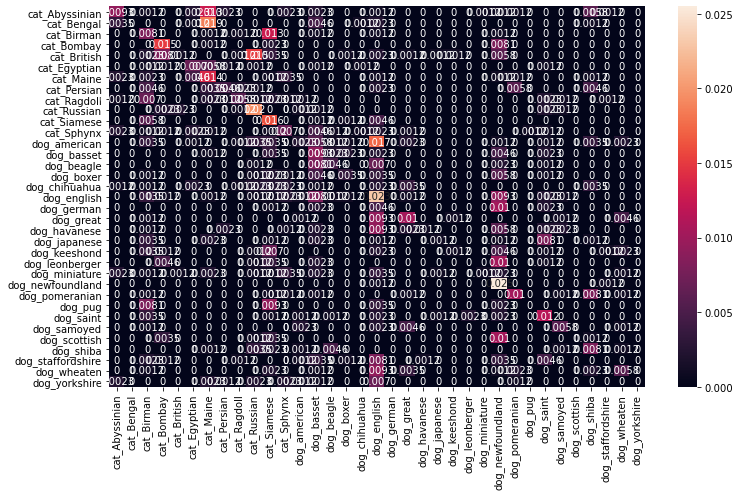

In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in dataloaders['val']:
    
    output = model_ft(inputs) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction
        
    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

# constant for classes


# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix), index = [i for i in image_datasets['train'].classes],
                     columns = [i for i in image_datasets['train'].classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

#### Выводы 
- Модель справилась с задачей неидеально 

# Кошки против собак

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'binar'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}



In [7]:
def one_hot(x):
    
    massiv = np.zeros(2)
    massiv[x] = 1
    return massiv


In [8]:
class MyConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(44944, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



    

model_ft = MyConvNet()



loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)


model_ft = train( 10,dataloaders['train'],model_ft)

На эпохе  1 доля верных ответов на тесте = 0.6613247863247863
На эпохе  2 доля верных ответов на тесте = 0.6485042735042735
На эпохе  3 доля верных ответов на тесте = 0.7286324786324786
На эпохе  4 доля верных ответов на тесте = 0.7382478632478633
На эпохе  5 доля верных ответов на тесте = 0.7831196581196581
На эпохе  6 доля верных ответов на тесте = 0.8344017094017094
На эпохе  7 доля верных ответов на тесте = 0.8226495726495726
На эпохе  8 доля верных ответов на тесте = 0.8333333333333334
На эпохе  9 доля верных ответов на тесте = 0.8878205128205128
На эпохе  10 доля верных ответов на тесте = 0.8899572649572649


<AxesSubplot:>

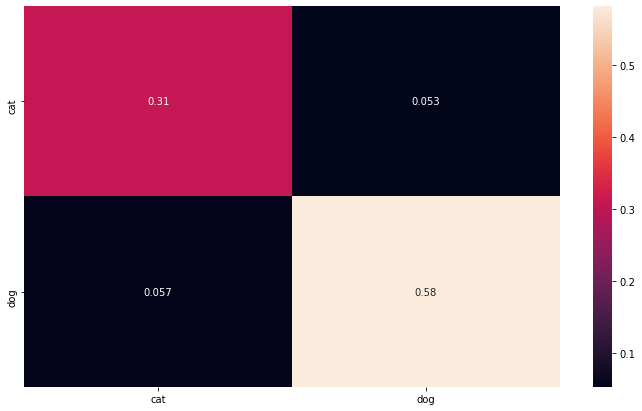

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in dataloaders['val']:
    
    output = model_ft(inputs) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction
        
    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

# constant for classes


# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) , index = [i for i in image_datasets['train'].classes],
                     columns = [i for i in image_datasets['train'].classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

#### Выводы 
- Модель справилась с задачей неплохо